In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data
import pandas_datareader.data as web



In [2]:
def getCloseDataPandas(ticker, start,end=None):
    #print("ticker: " ,ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    #print("ticker: " ,ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    plt.figure(figsize=(15,5))
    plt.plot(-dd, label="DrawDown")
    plt.legend(fontsize = 16)
    mdd = dd.max()
    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period , weightDf=None):
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
    portfolio = pd.DataFrame()
    totalAsset = 1 
    start = rebalancingDate[0] 
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end] 
        cumReturn = getCumulativeReturn(priceData) 
        weightedCumReturn = weight * cumReturn 
        netCumReturn = totalAsset * weightedCumReturn
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumReturn])
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] 
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 


# 1. 유대인전략 (한달에 한번 주식+채권)
- 파이썬 이용하여 유대인 전략 구현 및 백테스팅
- 백테스팅 기간: 최대한 길게
- 샤프지수 : Sharpe_rate = 수익률 / 변동성
- 수익률이 커도 변동성에 의해 샤프지수 바뀜


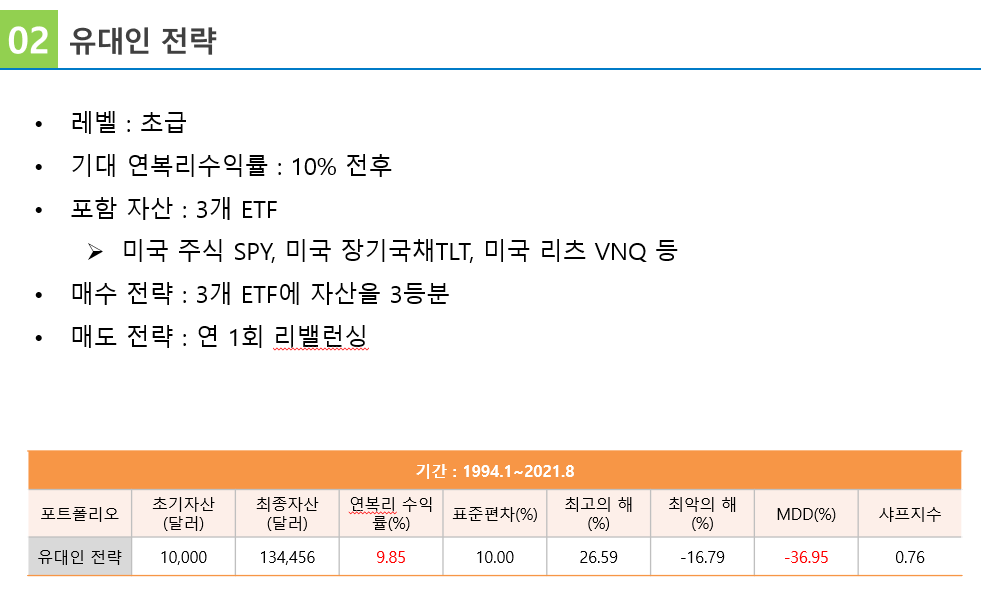


In [3]:
SPY.head()

NameError: name 'SPY' is not defined

In [73]:
TLT.head()

Date
2002-07-30    81.519997
2002-07-31    82.529999
2002-08-01    83.000000
2002-08-02    83.849998
2002-08-05    84.220001
Name: Close, dtype: float64

In [74]:
VNQ.head()

Date
2004-09-29    49.849998
2004-09-30    50.250000
2004-10-01    51.180000
2004-10-04    51.400002
2004-10-05    51.389999
Name: Close, dtype: float64

In [4]:
df_etf = fdr.StockListing('ETF/US')

#출처: https://seong6496.tistory.com/169 [파이프마임:티스토리]

KeyError: 'data-id'

In [ ]:
test

In [ ]:
aa

In [4]:
SPY = getCloseDataPandas("SPY","1994-01","2021-08") # 주식
TLT = getCloseDataPandas("TLT","1994-01","2021-08") # 예금, 채권
VNQ = getCloseDataPandas("VNQ","1994-01","2021-08") # 리츠

In [5]:
closeDataSet = pd.concat([SPY,TLT,VNQ], axis=1)
closeDataSet.columns = ["SPY","TLT","VNQ"]
closeDataSet.dropna(inplace = True)

In [6]:
rebalancingDate = getRebalancingDate(closeDataSet, "year")
rebalancingDate

DatetimeIndex(['2004-12-31', '2005-12-30', '2006-12-29', '2007-12-31',
               '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-30',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-30', '2017-12-29', '2018-12-31', '2019-12-31',
               '2020-12-31', '2021-07-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet,"year")

최종 수익률 : 2.6342940732713895
cagr: 1.0602226433216744
mdd: 43.89598782725451


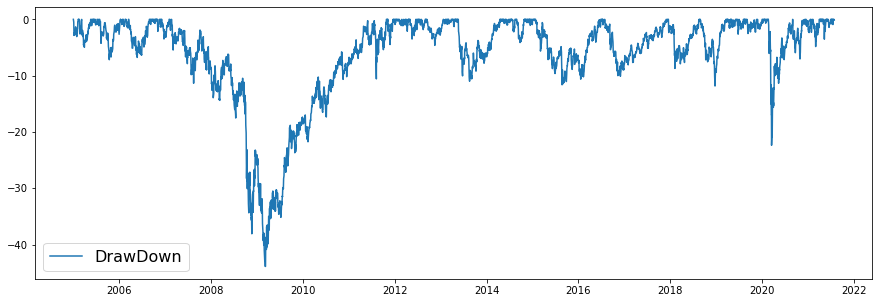

In [8]:
rebalCagr, rebalDD, rebalMDD = getEvaluation(rebalPortfolioCumulativeReturn)

# 2. 60/40 포트폴리오_미국
- 파이썬 이용하여 미국 주식 SPY에 60%, IEF에 40% 투자, 매도 전략  연 1회 리밸런싱구현 및 백테스팅
- 백테스팅 기간: 최대한 길게 => 데이터가 주어진 최대한으로 진행

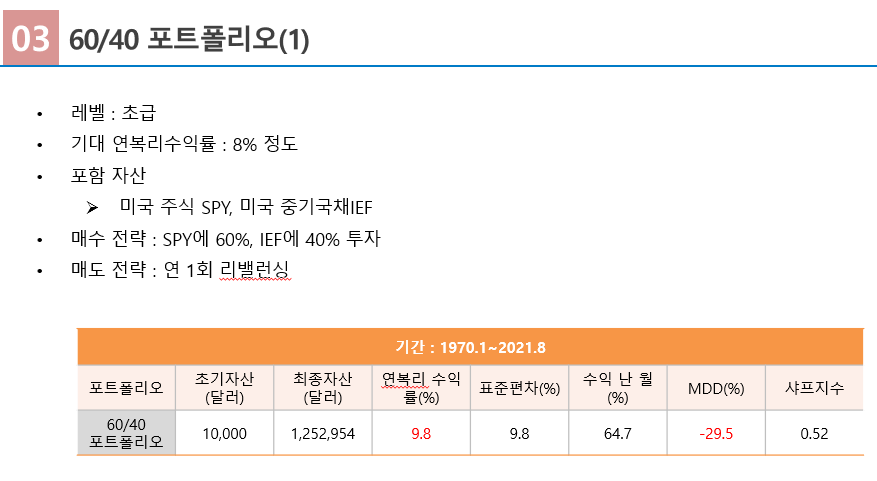

# 3. 60/40 포트폴리오_한국
- 파이썬 이용하여 한국 주식 코스피지수, 한국 장기국채에 각각 60%, 40% 투자. 연 1회 리밸런싱 전략 구현 및 백테스팅
- 백테스팅 기간: 최대한 길게


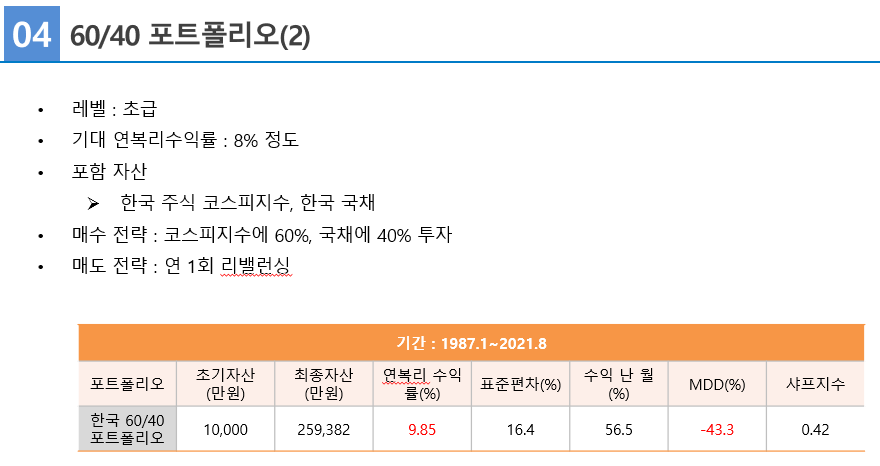

# 4. 영구 포트폴리오
- 넣어놓고 10년동안 안찾겠다
- 영구포트폴리오 전략을 파이썬 코드로 구현
- 백테스팅 및 성과분석


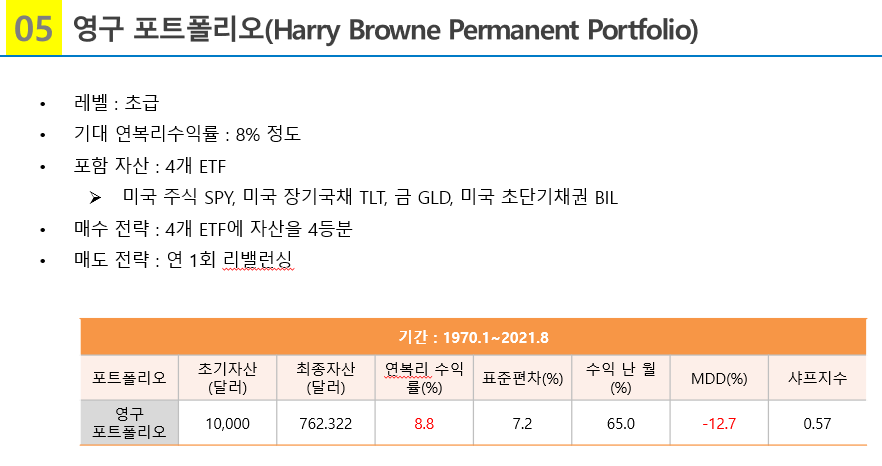

# 5. 4계절 포트폴리오
- 사이클에 따라 달라짐
- 4계절 포트폴리오 전략을 파이썬 코드로 구현
- 백테스팅 및 성과분석


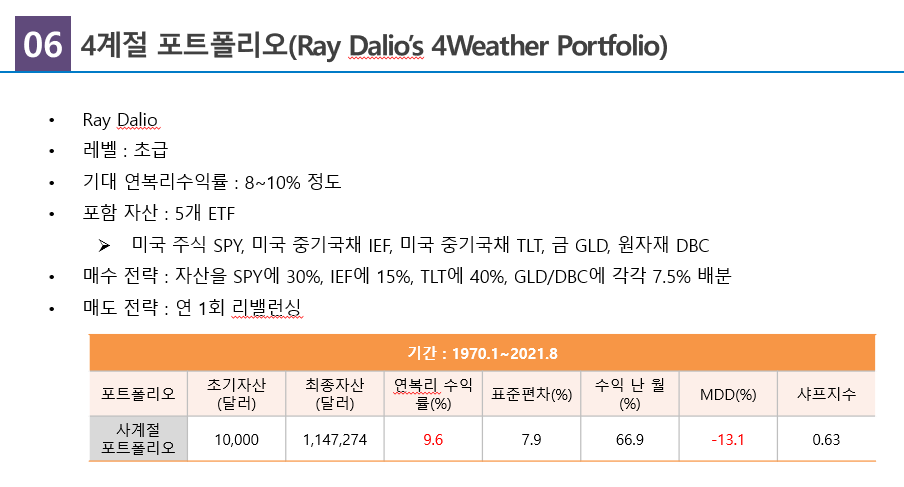

In [ ]:
므